This notebook is part of the "Literary Metaphor Detection
with LLM Fine-Tuning and Few-Shot Learning" paper. The corresponding repository can be found on [Github](https://github.com/ma-spie/LLM_metaphor_detection).

*goals of this notebook*:  


*   preprocessing: transform data to the right shape for training
*   data analysis: identify quantity of sentences and label balance



# Preprocessing datasets

## Imports and load data

In [4]:
#library imports
from google.colab import files  #only needed if Google colab is used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Upload these datasets. You can download them from the links below or from the folder raw_datasets in the repository:

* [PoFo_corpus.txt](https://www.site.uottawa.ca/~diana/resources/metaphor/type1_metaphor_annotated.txt)
* [TroFi_formatted_all3737.csv](https://github.com/YU-NLPLab/DeepMet/blob/master/data/TroFi/TroFi_formatted_all3737.csv)
* [MOH-X_formatted_svo_cleaned.csv](https://github.com/YU-NLPLab/DeepMet/blob/master/data/MOH-X/MOH-X_formatted_svo_cleaned.csv)


In [5]:
uploaded_files = files.upload()   #only needed if Google colab is used, otherwis these files have to be in the same folder as this notebook

Saving MOH-X_formatted_svo_cleaned.csv to MOH-X_formatted_svo_cleaned.csv
Saving PoFo_corpus.txt to PoFo_corpus.txt
Saving TroFi_formatted_all3737.csv to TroFi_formatted_all3737.csv


### Reformat PoFo

reformat PoFo_corpus.txt into PoFo_normallised.csv with two columns labeled "text" and "label"


In [6]:
with open("PoFo_corpus.txt", "r", encoding="utf-8") as f:
  lines = f.readlines()

with open("PoFo_corpus.csv", "w", encoding="utf-8") as f_out:
  f_out.write("text\tlabel\n")

  for line in lines:
    text, label = line.strip().rsplit(maxsplit=1)

    if label[-1] == "s":              #create dataset like Kesarwani et al. (2017) by excluding labels marked with "s" (skipped)
      continue

    get_label = label[-1]
    if get_label == "y":
      label = "metaphorical"
    elif get_label == "n":
      label = "literal"

    f_out.write(f"{text}\t{label}\n")

### Create pandas dataFrames for all datasets

In [7]:
PoFo_df = pd.read_csv("PoFo_corpus.csv", usecols=["text", "label"], sep="\t")
TroFi_df = pd.read_csv("TroFi_formatted_all3737.csv", usecols=["sentence", "label"])
MOH_df = pd.read_csv("MOH-X_formatted_svo_cleaned.csv", usecols=["sentence", "label"])

### Normalise TroFi and MOH

- column names: change "sentence" to "text"
- label names: "metaphorical", "lireral"
- delimiter: tab

In [8]:
TroFi_df.rename(columns={"sentence": "text"}, inplace=True)
TroFi_df["label"].replace({0: "literal", 1: "metaphorical"}, inplace=True)
TroFi_df

,text,label
0,An Energy Department spokesman says the sulfur...,literal
1,The yellow beta carotene pigment absorbs blue ...,literal
2,"This time , the ground absorbed the shock wave...",literal
3,'' Vitamins could be passed right out of the b...,literal
4,"As Eliot wrote : '' In a warm haze , the sultr...",literal
...,...,...
3732,But the OTC market was withering badly near th...,literal
3733,"But the ANC has grown , and black supremacist ...",literal
3734,The combination was supposed to make First Rep...,literal
3735,"Indeed , thanks to a well - oiled political ma...",literal


In [9]:
MOH_df.rename(columns={"sentence": "text"}, inplace=True)
MOH_df["label"].replace({0: "literal", 1: "metaphorical"}, inplace=True)
MOH_df

,text,label
0,He absorbed the knowledge or beliefs of his t...,metaphorical
1,He absorbed the costs for the accident .,metaphorical
2,The sales tax is absorbed into the state inco...,metaphorical
3,The immigrants were quickly absorbed into soc...,metaphorical
4,Her interest in butterflies absorbs her compl...,metaphorical
...,...,...
642,We had to swim for 20 minutes to reach the sh...,literal
643,She talks a lot of nonsense .,literal
644,He transformed into a monster .,metaphorical
645,Gun shots volleyed at the attackers .,literal


### Joined dataset
create a joined dataset that consists of PoFo, TroFi and MOH like it was done by Kesarwani et al. and Tanasescu et al.

In [10]:
PoFo_TroFi_MOH_df = pd.concat([PoFo_df, TroFi_df, MOH_df], axis=0)
PoFo_TroFi_MOH_df

,text,label
0,poise is a club .,metaphorical
1,destroying alexandria . sunlight is silence,metaphorical
2,feet are no anchor . gravity sucks at the mind,metaphorical
3,on the day 's horizon is a gesture of earth,metaphorical
4,he said good-by as if good-by is a number .,metaphorical
...,...,...
642,We had to swim for 20 minutes to reach the sh...,literal
643,She talks a lot of nonsense .,literal
644,He transformed into a monster .,metaphorical
645,Gun shots volleyed at the attackers .,literal


### Duplicate removal

when observing the joined datasets it gets clear that from 4946 sentences only 4796 are unique, meaning that there are 150 duplicate sentences:

In [11]:
PoFo_TroFi_MOH_df.info()
PoFo_TroFi_MOH_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 4946 entries, 0 to 646
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4946 non-null   object
 1   label   4946 non-null   object
dtypes: object(2)
memory usage: 115.9+ KB


,text,label
count,4946,4946
unique,4796,2
top,A revenue passenger mile is one paying passeng...,literal
freq,15,2706


The reason for duplicates is that since Kesarwani et al. and Tanasescu et al. used a word-level apprach to metaphor detection a single sentence could be classified both as literal and metaphorical considering different verbs for possible metaphoricity:


Out of 282 duplicates there are 245 sentences that have different labels assigned to them.

In [12]:
duplicates_sentences = PoFo_TroFi_MOH_df[PoFo_TroFi_MOH_df.duplicated(subset=["text"], keep=False)]
duplicates_sentences.describe()

,text,label
count,282,282
unique,132,2
top,A revenue passenger mile is one paying passeng...,literal
freq,15,183


In [13]:
duplicates_both_labels = duplicates_sentences[duplicates_sentences.duplicated(subset=["text", "label"], keep=False)]
duplicates_both_labels.describe()

,text,label
count,245,245
unique,114,2
top,A revenue passenger mile is one paying passeng...,literal
freq,15,165


since I use the sentence-level classification approach I decided to remove all duplicate sentences to avoid training on ambigious labels

In [14]:
PoFo_TroFi_MOH_df_nodup= PoFo_TroFi_MOH_df.drop_duplicates(subset=["text"], keep="first")
PoFo_df_nodup = PoFo_df.drop_duplicates(subset=["text"], keep="first")
TroFi_df_nodup = TroFi_df.drop_duplicates(subset=["text"], keep="first")
MOH_df_nodup = MOH_df.drop_duplicates(subset=["text"], keep="first")

### Saving preprocessed datasets for training and evaluation

In [15]:
PoFo_df_nodup.to_csv("PoFo_normalised.csv", sep="\t", index=False)
TroFi_df_nodup.to_csv("TroFi_normalised.csv", sep="\t", index=False)
MOH_df_nodup.to_csv("MOH-X_normalised.csv", sep="\t", index=False)
PoFo_TroFi_MOH_df_nodup.to_csv("PoFo_TroFi_MOH.csv", sep="\t", index=False)

# Data analysis

## 1. Quantity of sentences

In [16]:
PoFo_TroFi_MOH_df_nodup.describe()

,text,label
count,4796,4796
unique,4796,2
top,poise is a club .,literal
freq,1,2608


In [17]:
PoFo_df_nodup.describe()

,text,label
count,552,552
unique,552,2
top,poise is a club .,metaphorical
freq,1,292


In [18]:
TroFi_df_nodup.describe()

,text,label
count,3603,3603
unique,3603,2
top,An Energy Department spokesman says the sulfur...,literal
freq,1,2020


In [19]:
MOH_df_nodup.describe()

,text,label
count,641,641
unique,641,2
top,He absorbed the knowledge or beliefs of his t...,literal
freq,1,328


## Distribution of sentences across the datasets

This pie chart was plotted with the help of the Matplotlib API for [Pie charts](https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html#pie-charts).

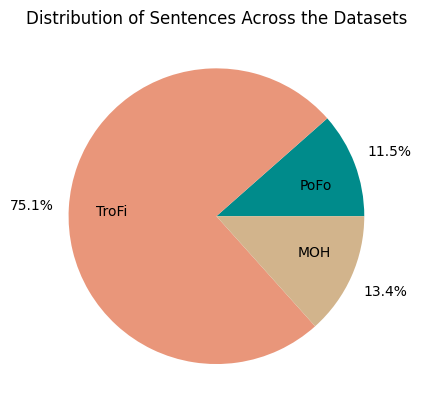

In [20]:
#plot pie chart:
labels = "PoFo", "TroFi", "MOH"
slices = [len(PoFo_df_nodup), len(TroFi_df_nodup),len(MOH_df_nodup)]

fig, ax = plt.subplots()
ax.pie(slices, labels=labels, autopct="%1.1f%%", colors=["darkcyan","darksalmon","tan"], pctdistance=1.25, labeldistance=.6)
plt.title("Distribution of Sentences Across the Datasets")
plt.savefig("Distribution of Sentences Across the Datasets.png")
plt.show()


## 2. Distribution of classes

In [21]:
PoFo_counts = PoFo_df_nodup["label"].value_counts()
PoFo_counts

label
metaphorical    292
literal         260
Name: count, dtype: int64

In [22]:
TroFi_counts = TroFi_df_nodup["label"].value_counts()
TroFi_counts

label
literal         2020
metaphorical    1583
Name: count, dtype: int64

In [23]:
MOH_counts = MOH_df_nodup["label"].value_counts()
MOH_counts

label
literal         328
metaphorical    313
Name: count, dtype: int64

In [24]:
PoFo_TroFi_MOH_df_counts = PoFo_TroFi_MOH_df_nodup["label"].value_counts()
PoFo_TroFi_MOH_df_counts

label
literal         2608
metaphorical    2188
Name: count, dtype: int64

This bar chart was plotted with the help of the Matplotlib API for [Grouped bar chart with labels](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#grouped-bar-chart-with-labels).

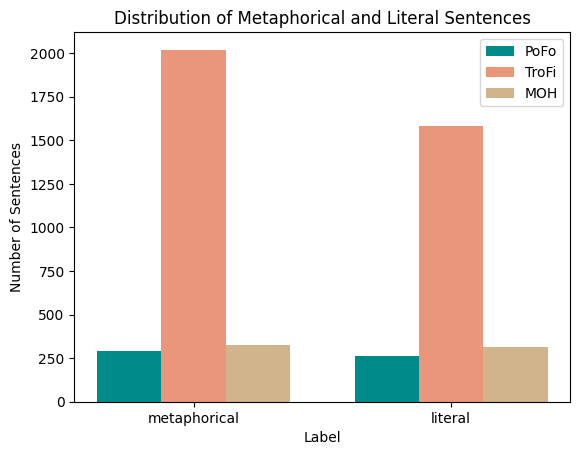

In [25]:
#plot barplot:
labels = ["metaphorical", "literal"]
x = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, PoFo_counts, width, label="PoFo", color="darkcyan")
rects2 = ax.bar(x, TroFi_counts, width, label="TroFi", color="darksalmon")
rects3 = ax.bar(x + width, MOH_counts, width, label="MOH", color="tan")

ax.set_xlabel("Label")
ax.set_ylabel("Number of Sentences")
ax.set_title("Distribution of Metaphorical and Literal Sentences")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig("Distribution of Metaphorical and Literal Sentences.png")
plt.show()

As a result we get


*   4 normalised datasets in csv format which will be used for fine-tuning and evaluation
*   a visualisation called "Distribution of Sentences Across the Datasets.png"
*  a visualisation called "Distribution of Metaphorical and Literal Sentences.png"



# Works cited

Kesarwani, Vaibhav, et al. “Metaphor Detection in a Poetry Corpus.” *Proceedings of the Joint SIGHUM Workshop on Computational Linguistics for Cultural Heritage, Social Sciences, Humanities and Literature, Vancouver, Canada*, edited by Beatrice Alex et al. Stroudsburg, PA, USA. Association for Computational Linguistics, pp. 1–9, [https://doi.org/10.18653/v1/W17-2201](https://doi.org/10.18653/v1/W17-2201).



Tanasescu, Chris, et al. “Metaphor Detection by Deep Learning and the Place of Poetic Metaphor in Digital Humanities.” *The thirty-first international flairs conference*, 2018, pp. 122–127, [aaai.org/papers/122-flairs-2018-17704/](https://aaai.org/papers/122-flairs-2018-17704/).